## What Marty Did, featuring some upgrades
Previously, $c(t)$ had shape $[1:Np,1:Np]$. This worked for $Nc=1$ (e.g. just one corridor connecting two patches) but did not explicitly specify the number of corridors between any two patches.

Now, $c(t)$ has shape $[1:Np,1:Np,1:Nc]$. This allows us to specify the specific corridor of interest, since there might be more than one corridor connecting the same two patches. For instance, $c_{1,2,1}$ and $c_{1,2,2}$ both connect patch 1 $\to$ patch 2.

Reminder: $c_{i,j,k}$ means ``corridor $k$ connecting patch $i$ to patch $j$''.

In [24]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#An attempt to use vecorized representation for the standard Lotka-Volterra model.

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=1

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] #note, this is only for 1 corridor and will have to be modifed.

#=
Note, think about generalizing c(t) for multiple corridors... i.e. c(t)[1:Nc,1:Np,1:Np]
I have not tested this, but this shold make a Nc x Np x Np array.
=#


@parameters α[1:Nc] 
@parameters β[1:Nc] 
@parameters d[1:Np]

#=

Note, think about generalizing the above for directions, i.e. add more dimensions
to the array where, again, there will be lots of zeros...

=#

#=
define a general flux at a node connection (between a patch and a corridor),
that is, the flux entering and exiting corridors. All fluxes are defined for 
corridors, not patches.  Net Fluxes for patches are then summed over all corridors
connected to a patch, i.e. sum in - sum out. This should allow us to write the patch 
fluxes and corridor fluxes in a very systematic way, and we should end up with 
something like

D.(p) = NPF
D.(c) = NCF

where NPF and NCF are the net patch and corridor fluxes appropriately defined.

=#

EnFlx(p,c,d,α,β) = d * exp(-α * β * c) * p
ExFlx(c,β) = exp(-β*c)*c

#=
so, for example, the fluxes from p1 and p2 into corridor 1 would be

EnFlx(p[1],c[1,2],d[1],α[1],β[1])
EnFlx(p[2],c[2,1],d₂,α₂,β₂)

etcetera

=#

#define the corridor flux matrix

eqs = [
    D.(p[1]) ~ ExFlx(c[2,1,1],β[1]) - EnFlx(p[1],c[1,2,1],d[1],α[1],β[1]),
    D.(p[2]) ~ ExFlx(c[1,2,1],β[1]) - EnFlx(p[2],c[2,1,1],d[2],α[1],β[1]),
    D.(c[1,2,1]) ~ - ExFlx(c[1,2,1],β[1]) + EnFlx(p[1],c[1,2,1],d[1],α[1],β[1]),
    D.(c[2,1,1]) ~ - ExFlx(c[2,1,1],β[1]) + EnFlx(p[2],c[2,1,1],d[2],α[1],β[1]) 
]

#define equations

#eqs = [
 #   D.(p) ~ collect(c*p)
  #      ]

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 4 equations
Unknowns (4):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 2, 1]
  (c(t))[2, 1, 1]
Parameters (3):
  α
  β
  d

Marty's note: OK, so this works beautifully, and if you stare at it for a while you should be able to generalize. But first, create the numerical problem and solve it... Notice that it didn't complain about us not using c[1,1] and c[2,2]. But when we generalize, these will all be there, but set to zero.  Maybe the best way to proceed is to just have this file with subseqent cells as incremental generalizations.

## Numerical problem and solution
Still assuming only one corridor ($Nc=1$) connecting any two patches. Notice that "self-loops" (like $c_{1,1,1}$) are set to have zero population.

2-element Vector{Float64}:
 0.8
 0.0

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.1
 0.1  0.0

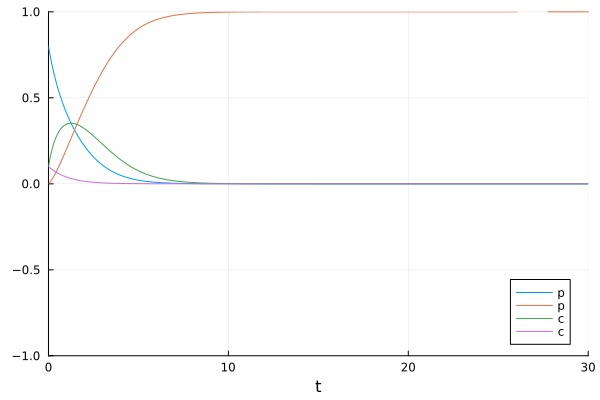

In [26]:
# build numerical problem to solve

# Set parameters
my_α = [1]    # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = [1]    # Inverse road capacity (for now, assume same for all corridors)
my_d = [1; 0] # Fraction of population desiring to leave patch i

# Set initial conditions (should sum to 1)
# PatchMatrix: initial population of each patch
pm = [0.8; 0.0]
display(pm)
# CorridorMatrix: initial population of each corridor
cm = zeros(2,2,1)  
cm[1,2,1] = 0.1
cm[2,1,1] = 0.1
display(cm)

# Create problem
prob = ODEProblem(model, [p=>pm,c=>cm], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])

#=
Note: it is not strictly necessary to define the initial conditions of the full c and p matrices in advance. 
We could also have simply said:
    `prob = ODEProblem(model, [p[1]=>0.8,p[2]=>0.0,c[1,2,1]=>0.1,c[2,1,1]=>0.1], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])`
Notice that this approach does not define all the values of c; 
we could choose to only define the values of interest (e.g. the non-zero values). 
But personally, I like the uncommented way better because it's more explicit.
=#

#numerically solve the problem and plot it

sol = solve(prob,Tsit5())
plot(sol, idxs = (p[1]), ylim=(-1,1))
plot!(sol, idxs = (p[2]), xlim=(0,30))
plot!(sol, idxs = (c[1,2,1]))
plot!(sol, idxs = (c[2,1,1]))

## More generally
I don't want to manually define the value of each index of $p[i]$ and $c[i,j,k]$ in `eqs` every time. That would require me to know the size of $Np$ and $Nc$ in advance, and hardcode the `eqs` accordingly. Instead, here is a vectorized version. To check whether the reported equations are correct, I have also created some diagrams to help keep track of the terms.

![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_1.png?raw=true)
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_2.png?raw=true)

## Equations we would expect
This final diagram shows the equation would expect for $\frac{dp(t)_1}{dt}$ (sum along the green columns, subtract the sum along the yellow rows).
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_3.png?raw=true)

In [2]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=2

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] # notice that we must specify the number of corridors (layers) in the *last* index

@parameters α[1:Np]
@parameters β[1:Nc]
@parameters d[1:Np]

#define the corridor flux matrices
#notice the use of `.` notation before each arithmetic operation, but NOT before `=`

EnFlx(p,c,d,α,β) = exp.(-α .* β .* c) .* p .* d
ExFlx(c,β) = exp.(-β.*c).*c

#define equations
#notice there are only two equations, regardless of the size of Np or Nc

eqs = [
    D.(p) ~ [sum(ExFlx(c,β[1])[:,i,:]) for i in 1:Np] .- [sum(EnFlx(p,c,d,α[1],β[1])[i,:,:]) for i in 1:Np],
    D.(c) ~ collect(-ExFlx(c,β[1]) + EnFlx(p,c,d,α[1],β[1])),
]
#=
  Notice we only used "collect()" in the equation for D.(c). 
  For D.(p), we summed over the columns of the EnFlx matrix and over the columns of the ExFlx matrix, 
  then took their difference. If you don't do this (summing), you will get an error because you will be 
  attempting to save an object of shape (2,2,1) into an object of shape (2,).
=#

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 10 equations
Unknowns (10):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
  (c(t))[1, 2, 1]
  (c(t))[2, 2, 1]
⋮
Parameters (3):
  β[1]
  α[1]
  d

## Numerical solve and plot solution
Notice `my_\beta` is now `10` instead of `1` for all corridors. Also the initial conditions have completely changed (I wanted to be able to clearly see the difference between each curve.)

2-element Vector{Float64}:
 0.6
 0.0

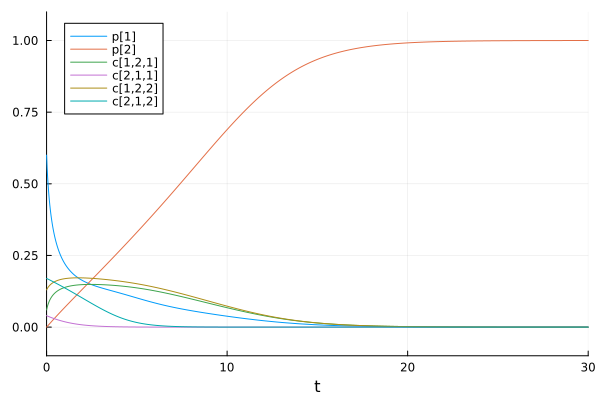

In [3]:
# build numerical problem to solve

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = [10]    # Inverse road capacity (for now, assume same for all corridors)
my_d = [1; 0]  # Fraction of population desiring to leave patch i

# Set initial conditions (should sum to 1)
# PatchMatrix: initial population of each patch
pm = [0.6; 0.0]
display(pm)
# CorridorMatrix: initial population of each corridor
cm = zeros(2,2,2)
cm[1,2,1] = 0.06
cm[2,1,1] = 0.04
cm[1,2,2] = 0.13
cm[2,1,2] = 0.17

# Create problem
prob = ODEProblem(model, [p=>pm,c=>cm], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])

#numerically solve the problem and plot it

sol = solve(prob,Tsit5())
plot(sol, idxs = (p[1]), ylim=(-0.1,1.1), label="p[1]")
plot!(sol, idxs = (p[2]), xlim=(0,30), label="p[2]")
plot!(sol, idxs = (c[1,2,1]), label="c[1,2,1]")
plot!(sol, idxs = (c[2,1,1]), label="c[2,1,1]")
plot!(sol, idxs = (c[1,2,2]), label="c[1,2,2]")
plot!(sol, idxs = (c[2,1,2]), label="c[2,1,2]")

## Call from help functions file
Let's see if we can do all of this faster, in a more streamlined way.

In [34]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs

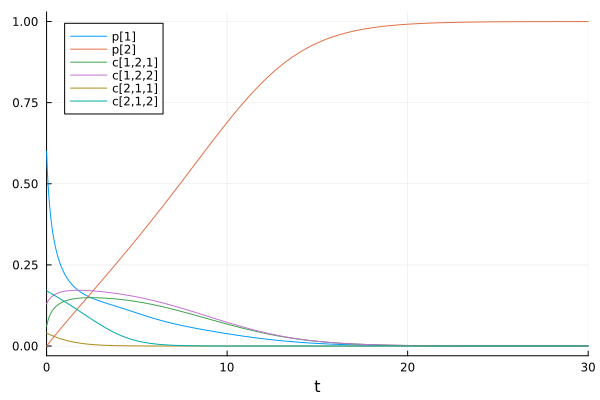

In [40]:
# Set initial conditions
pm = [0.6; 0.0]
cm = zeros(2,2,2)
cm[1,2,1] = 0.06
cm[2,1,1] = 0.04
cm[1,2,2] = 0.13
cm[2,1,2] = 0.17

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = [10]    # Inverse road capacity (for now, assume same for all corridors)
my_d = [1; 0]  # Fraction of population desiring to leave patch i

model, prob, plt = HelpFuncs.build_symbolic_model(Np=2, Nc=2, pm=pm, cm=cm, my_α=my_α, my_β=my_β, my_d=my_d)
display(plt)

## Old stuff (Marty please ignore)

In [ ]:
my_α = [1]
my_β = [1]
my_d = [0 1; 0 0]
cm = zeros(2,2,1)
cm[1,2,1] = 0.15
cm[2,1,1] = 0.05
pm = [0.8; 0.0]

EnFlx(p,c,d,α,β) = d .* exp.(-α .* β .* c) .* p
ExFlx(c,β) = exp.(-β.*c).*c

en_flux = EnFlx(pm, cm, my_d, my_α, my_β)
exit_flux = ExFlx(cm, my_β)

display(en_flux)
display(exit_flux)

pm_minus = [sum(en_flux[i, :, :]) for i in 1:Np] # row i, all columns, first "layer"
pm_plus = [sum(exit_flux[:, i, :]) for i in 1:Np] # all rows, column i, first "layer"

display(pm_minus)
display(pm_plus)

new_pm = pm_plus .- pm_minus
display(new_pm)